# Couple a simple single column model to the RRTMG scheme and explore ECS

The thermal structure of the atmosphere is assumed to follow the pseudoadiabatic lapse rate in the troposphere, with an overlying isothermal stratosphere at a fixed tropopause temperature, following Seeley and Jeevanjee (2020).

In [7]:
%matplotlib inline 
import climlab
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate as sp  #Gives access to the ODE integration package
from attrdict import AttrDict

In [12]:
class Dummy:
    pass

params = Dummy()

params.eps   = 0.622 # molar mass ratio of vapour to total moist air
params.L     = 2260000 # Latent heat of vap, water, J/kg

params.R_a   = 287.058 # gas constant for dry air, J/kg/K
params.R_c   = 461.5  # gas constant for water vapour, J/kg/K
params.cp_a  = 1004 # specific heat capacity of air, J/kg/K

params.Tstrat = 200 # isothermal stratosphere, K

In [69]:
# Define functions

def q(T, P): # specific humidity at saturation (using Clausius-Clapeyron)
    return climlab.utils.thermo.qsat(T, P)

def moist_adiabat(T, P): # Pressure coords gives dT/dP (if using the T/P prefactor)
    return np.divide(T, P) * np.divide(params.R_a, params.cp_a) * np.divide(1 + np.divide(params.L*q(T, P), params.R_a * T), 
                                                                            1 + np.divide(params.L**2 * q(T, P), params.cp_a * params.R_c * T**2))

# Or, equivalently...
def pseudoadiabat(T,p):
    return climlab.utils.thermo.pseudoadiabat(T, p)

def dry_adiabat(T):
    return np.divide(params.params.R_a, cp_a)

def generate_idealized_temp_profile(SST, Tstrat, plevs):
    solution = sp.odeint(pseudoadiabat, SST, np.flip(plevs))
    temp = solution.reshape(-1)
    temp[np.where(temp<Tstrat)] = Tstrat
    return temp

In [166]:
def test_olr(SST, CO2):
    ## RRTMG
    #  Couple water vapor to radiation
    ## climlab setup
    # create surface and atmosperic domains
    sfc, atm = climlab.domain.single_column(num_lev=60, num_lat=1, water_depth=5.)

    # create atmosheric state
    state = AttrDict()

    # assign surface temperature and vertical temperature profiles
    Ts_ = climlab.Field(np.array([SST]), domain=sfc)
    state['Ts'] = Ts_

    temp = generate_idealized_temp_profile(SST, 
                                           params.Tstrat, 
                                           atm.axes['lev'].points)
    Tatm = climlab.Field(temp, domain=atm)
    state['Tatm'] = Tatm

    #  Create a parent process
    rce = climlab.TimeDependentProcess(state=state)
    
    ## Create individual physical process models:
    #  fixed relative humidity
    h2o = climlab.radiation.water_vapor.FixedRelativeHumidity(state=state)
    h2o.RH_profile = 0.8
    # RRTMG radiation
    rad = climlab.radiation.RRTMG(state=state, specific_humidity=h2o.q, albedo=0.2, ozone_file=None)
    rad.subprocess['LW'].absorber_vmr = {'CO2':CO2/1e6,
                                         'CH4':0.,
                                         'N2O':0.,
                                         'O2':0.,
                                         'CFC11':0.,
                                         'CFC12':0.,
                                         'CFC22':0.,
                                         'CCL4':0.,
                                         'O3':0.
                                        }
    
    # Couple the models
    rce.add_subprocess('Radiation', rad)
    rce.add_subprocess('H2O', h2o)

    rce.compute()
    olr = rce.OLR[0]
    #print(olr,end="\n")
    return olr, rce.to_xarray(rce.diagnostics)

In [167]:
OLR0, m = test_olr(SST=288,CO2=280)
OLR0

375.54275170382147

In [169]:
test_olr(SST=290,CO2=640)[0] - OLR0

10.749576983534894

In [124]:
OLRS = np.zeros((10,10))

for idx1, temp in enumerate(np.linspace(280, 290, 10)):
    for idx2, co2 in enumerate(np.linspace(280, 1200, 10)):
        OLRS[idx1, idx2],_ = test_olr(temp, co2)

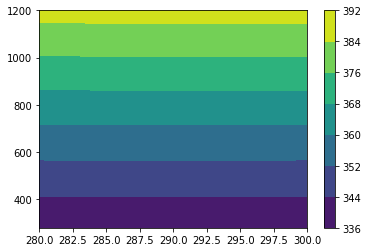

In [125]:
fig, ax = plt.subplots()
p=ax.contourf(np.linspace(280, 300, 10),np.linspace(280, 1200, 10),OLRS)
fig.colorbar(p)

In [30]:
%%time

TEMPS = np.linspace(280, 285, 6) #np.linspace(280, 320, 41)
CO2_arr = np.zeros(len(TEMPS))

co2_init = 280
for idx,sst in enumerate(TEMPS):
    print(sst)
    olr = test_olr(SST=sst,CO2=co2_init)
    co2=co2_init
    while abs(olr-OLR0)>0.1:
        if olr-OLR0>0:
            co2+=1
            olr = test_olr(SST=sst,CO2=co2)
        if olr-OLR0<0:
            co2-=1
            olr = test_olr(SST=sst,CO2=co2)
        print(co2)
    CO2_arr[idx] = co2

280.0
279
278
277
276
275
274
273
272


KeyboardInterrupt: 

In [242]:
CO2_arr

array([0., 0., 0., 0., 0., 0.])

In [16]:
300e-6

0.0003

In [25]:
state = climlab.column_state(lev=30, num_lat=1, water_depth=1.)
model = climlab.TimeDependentProcess(state=state)

conv = climlab.convection.ConvectiveAdjustment(state=state, adj_lapse_rate='MALR')
abs_vmr = climlab.radiation.radiation.default_absorbers(model.Tatm)
abs_vmr = {'CO2':300e-6*np.ones(30),
           'CH4':0.,
           'N2O':0.,
           'O2':0.,
           'CFC11':0.,
           'CFC12':0.,
           'CFC22':0.,
           'CCL4':0.,
           'O3':0.
          }

h2o = climlab.radiation.water_vapor.FixedRelativeHumidity(state=model.state)
h2o.RH_profile = 0.8
rad = climlab.radiation.RRTMG(state=state,
                             specific_humidity=h2o.q,
                             albedo = 0.3,
                             absorber_vmr = abs_vmr)

model.add_subprocess('Radiation', rad)
model.add_subprocess('ConvectiveAdjustment', conv)
model.add_subprocess('WaterVapor', h2o)

Opened data from /opt/anaconda3/envs/rce_bump/lib/python3.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc


In [ ]:
# assign surface temperature and vertical temperature profiles
    Ts_ = climlab.Field(np.array([SST]), domain=sfc)
    state['Ts'] = Ts_

    temp = generate_idealized_temp_profile(SST, 
                                           params.Tstrat, 
                                           atm.axes['lev'].points)
    Tatm = climlab.Field(temp, domain=atm)
    state['Tatm'] = Tatm

In [ ]:
def run_column_fixedRH(atm_input, rh_input, gcm_p, co2_lev=3e-4, insol=175.2, alb=0.54,surf_forc=0):
    
    state = climlab.column_state(lev=gcm_p, num_lat=1, water_depth=1.)
    model = climlab.TimeDependentProcess(state=state)
    
    conv = climlab.convection.ConvectiveAdjustment(state=state, adj_lapse_rate='MALR')
    abs_vmr = climlab.radiation.radiation.default_absorbers(model.Tatm)
    abs_vmr['CO2']=co2_lev
    h2o = climlab.radiation.water_vapor.FixedRelativeHumidity(state=model.state)
    h2o.RH_profile = rh_input
    rad = climlab.radiation.RRTMG(state=state,
                                 specific_humidity=h2o.q,
                                 albedo = alb,
                                 insolation = insol,
                                 absorber_vmr = abs_vmr)
    myforcing = ExternalForcing(state=state)
    myforcing.forcing_tendencies['Tatm']=atm_input
    myforcing.forcing_tendencies['Ts']=surf_forc
    model.add_subprocess('Radiation', rad)
    model.add_subprocess('ConvectiveAdjustment', conv)
    model.add_subprocess('WaterVapor', h2o)
    model.integrate_years(1,False)
    return model